In [3]:
import numpy as np
import pandas as pd 
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import uproot
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import comb
from scipy.stats import chi2

import math

import sys
import os 
from plot_tools import *
from customStats import *
import tools
import common_tools
# from selection_cuts import selection_nominal

import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['font.size'] = 24
plt.figure()
plt.close()
plt.rcParams.update({'figure.figsize':[10,8]})
plt.rcParams.update({'font.size':24})

import xgboost as xgb
# from loadCutXGB import load_and_cutXGBclfs

In [ ]:
ERA="2022"
YEAR='20'+ ERA.split("20")[1]
path = f'/cms/data/rreyesal/Bphysics/Bstomumuphi_{YEAR}/'
qsBinning=[]
#if args.decay == 'nonResonant':
qsBinning = ["bin"+str(i+1) for i in range(8)]
qsBinning.remove("bin4")
qsBinning.remove("bin6")
#elif args.decay == 'ResonantJpsi':
#    qsBinning = ["bin4"]
#elif args.decay == 'ResonantPsi':
#    qsBinning = ["bin6"]

In [3]:
## L O A D   F I L E S 

samples=['8','9']

f1 = os.path.join(path,f'ntuple_mumuphi_year{YEAR}_sample2_GEN.root')
f2 = os.path.join(path,f'ntuple_mumuphi_year{YEAR}_sample3_GEN.root')
f3 = os.path.join(path,f'ntuple_mumuphi_year{YEAR}_sample8_GEN.root')
f4 = os.path.join(path,f'ntuple_mumuphi_year{YEAR}_sample9_GEN.root')
f5 = os.path.join(path,f'ntuple_mumuphi_year{YEAR}_sample8_MINIAODSIM.root')
f6 = os.path.join(path,f'ntuple_mumuphi_year{YEAR}_sample9_MINIAODSIM.root')

genNFtr_pre = uproot.open(f1)['treeBs'].arrays(library='pd')
genNFtr_post = uproot.open(f2)['treeBs'].arrays(library='pd')
genFtr_pre = uproot.open(f3)['treeBs'].arrays(library='pd')
genFtr_post = uproot.open(f4)['treeBs'].arrays(library='pd')
recoFtr_pre = uproot.open(f5)['treeBs'].arrays(library='pd')
recoFtr_post = uproot.open(f6)['treeBs'].arrays(library='pd')

#genNFtr = genNFtr_pre #.sample(frac=0.5)
#genFtr =  genFtr_pre#.sample(frac=0.5)
#recoFtr = recoFtr_pre#.sample(frac=0.5)
genNFtr = pd.concat([genNFtr_pre, genNFtr_post])
genFtr  = pd.concat([genFtr_pre, genFtr_post])
recoFtr = pd.concat([recoFtr_pre, recoFtr_post])

#genNFtr = genNFtr.sample(frac=0.5)
#genFtr =  genFtr.sample(frac=0.5)
#recoFtr = recoFtr.sample(frac=0.5)


In [4]:
## Filter the Data
sys.path.append('/cms/home/rreyes/Bphysics/btosll/analysis/scripts/')
from selection_cuts import *
# Apply  the filters 
genNFtr["q2Gen"]= genNFtr.massJGen**2
genFtr["q2Gen"]= genFtr.massJGen**2
recoFtr["q2Gen"]= recoFtr.massJGen**2


GenFlt      = pd.DataFrame()
GenNFlt     = pd.DataFrame()
RecoGenFlt  = pd.DataFrame()
Reco        = pd.DataFrame()

GenNFlt = genNFtr.copy()

fltrGenNF =  Filters(genNFtr)
GenFlt = genNFtr[fltrGenNF].copy()

fltrGenF =  Filters(genFtr)
RecoGenFlt = genFtr[fltrGenF].copy()

fltrRecoF = selection_nominal(recoFtr,"nonResonant", True)
recoFtr = recoFtr[fltrRecoF]
Reco = load_and_cutXGBclfs(recoFtr,ERA,True)#True DataFrame to be cutted


from sklearn.model_selection import train_test_split

eff_Gen, obs_Gen = train_test_split( GenNFlt , test_size=0.1, random_state=42)
eff_GenFtr, obs_GenFtr = train_test_split( GenFlt , test_size=0.1, random_state=42)
eff_RecoGenFtr,  obs_RecoGenFtr = train_test_split( RecoGenFlt , test_size=0.1, random_state=42)
eff_RecoFtr, obs_RecoFtr = train_test_split( Reco , test_size=0.1, random_state=42)

data len before xgboost: 2347912
(XGB_f1 > 0.993) 
data len after xgboost: 934428


In [5]:
a1, a2, a3 = np.array(obs_Gen["costhetalGen"]), np.array(obs_Gen["costhetakGen"]), np.array(obs_Gen["phiGen"])

In [6]:
angles = np.array([a1, a2, a3])
valid_observations_mask = ~np.isnan(angles).any(axis=0)

# Filter the data to include only valid observations
filtered_data = angles[:, valid_observations_mask]

Matriz de correlación:
           $\cos{\theta_lep}$  $\cos{\theta_K}$    $\phi$
$\cos{\theta_lep}$   [ 1.00000000e+00  3.18993825e-04 -7.91569033e-04]
$\cos{\theta_K}$   [ 3.18993825e-04  1.00000000e+00 -1.33691851e-03]
$\phi$        [-7.91569033e-04 -1.33691851e-03  1.00000000e+00]


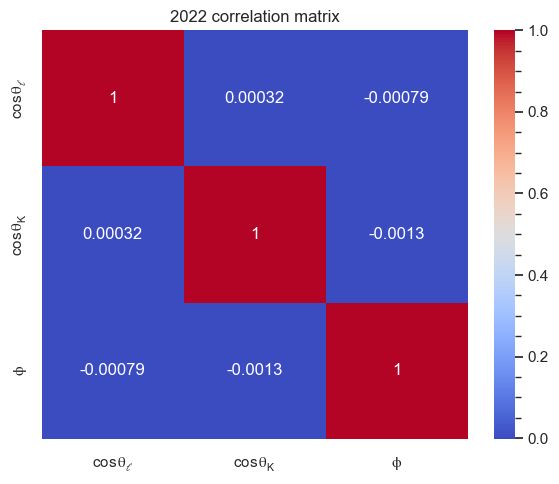

In [9]:
#corr = np.corrcoef(obs_Gen["costhetalGen"], obs_Gen["costhetakGen"])

#angles = np.vstack([obs_Gen["costhetalGen"], obs_Gen["costhetakGen"], obs_Gen["phiGen"]])
corr_matrix = np.corrcoef(filtered_data)

# --- CorrelationMatrix ---
print("Matriz de correlación:")
print("           $\cos{\\theta_lep}$  $\cos{\\theta_K}$    $\phi$")
print("$\cos{\\theta_lep}$  ", corr_matrix[0])
print("$\cos{\\theta_K}$  ", corr_matrix[1])
print("$\phi$       ", corr_matrix[2])

# --- HeatMap with seaborn ---
sns.set(style="whitegrid")
plt.figure(figsize=(6, 5)) 
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", 
            xticklabels=["$\cos{\\theta_{\ell}}$", "$\cos{\\theta_K}$", "$\phi$"], 
            yticklabels=["$\cos{\\theta_{\ell}}$", "$\cos{\\theta_K}$", "$\phi$"])
plt.title(f"{ERA} correlation matrix")
plt.tight_layout()
    
    #plt.savefig(f"angularEffs{era}/corrMatrix_{binN}.pdf",  bbox_inches='tight')
    #plt.show()

In [5]:
from scipy.special import comb
from scipy.optimize import lsq_linear

def bernstein_1d(n, k, t):
    """Bernstein base polynomial B_{n,k}(t) on t in [0,1]."""
    return comb(n, k) * (t**k) * ((1.0 - t)**(n - k))


def bernstein2d_matrix(nx, ny, x, y):
    """
    Build the design matrix for Bernstein2D basis.
    Input:
        x, y in [-1,1] (arrays)
    Output:
        B matrix of size (Npoints, (nx+1)*(ny+1))
    """
    # map [-1,1] -> [0,1]
    tx = 0.5*(x + 1.0)
    ty = 0.5*(y + 1.0)

    B_list = []
    for i in range(nx+1):
        for j in range(ny+1):
            B_list.append(bernstein_1d(nx, i, tx) * bernstein_1d(ny, j, ty))
    B = np.vstack(B_list).T   # shape (Npoints, Ncoef)
    return B

# ======================================================
# 2) Fit Bernstein2D to a 2D efficiency map
# ======================================================
def fit_bernstein2d(
    xcenters,
    ycenters,
    eff2d,
    ngen2d,
    nx=8,
    ny=8,
    min_counts_mask=None,
    reg_lambda=1e-10,
):
    """
    Fits a Bernstein2D polynomial to a 2D efficiency map using least squares + Tikhonov reg.

    Inputs:
        xcenters, ycenters   1D arrays (bin centers)
        eff2d                2D array with efficiency values (NaNs allowed)
        nx, ny               polynomial orders
        min_counts_mask      Boolean 2D mask (valid bins: True)
        reg_lambda           regularization parameter

    Returns:
        coef                 fitted coefficients
        eff_model            modeled efficiency on the grid

    
    Weighted fit of a Bernstein2D polynomial to a 2D efficiency map.

    The weights are derived from binomial uncertainties:
        sigma^2 = eff * (1 - eff) / ngen
    """

    XX, YY = np.meshgrid(xcenters, ycenters, indexing="ij")
    xflat = XX.ravel()
    yflat = YY.ravel()
    eff_flat = eff2d.ravel()
    ngen_flat = ngen2d.ravel()

    # Valid bins
    if min_counts_mask is None:
        use = (~np.isnan(eff_flat)) & (ngen_flat > 0)
    else:
        use = (
            min_counts_mask.ravel()
            & ~np.isnan(eff_flat)
            & (ngen_flat > 0)
        )

    x_use = xflat[use]
    y_use = yflat[use]
    eff_use = eff_flat[use]
    ngen_use = ngen_flat[use]

    
    # Binomial uncertainty
    sigma2 = eff_use * (1.0 - eff_use) / ngen_use
    sigma2 = np.clip(sigma2, 1e-12, None)  # numerical safety

    w = 1.0 / np.sqrt(sigma2)

    # Bernstein basis
    B = bernstein2d_matrix(nx, ny, x_use, y_use)

    # Apply weights
    Bw = B * w[:, None]
    yw = eff_use * w

    # Regularized weighted least squares
    BTB = Bw.T @ Bw + reg_lambda * np.eye(B.shape[1])
    BTy = Bw.T @ yw

    coef = np.linalg.solve(BTB, BTy)

    # Optional: mild physical constraint
    #coef = np.clip(coef, 0.0, 1.0)

    # Reconstruct on full grid
    Bfull = bernstein2d_matrix(nx, ny, xflat, yflat)
    eff_model_flat = Bfull @ coef
    eff_model = eff_model_flat.reshape(eff2d.shape)

    #plt.scatter(#eff_flat, #eff_model, #c=ngen_flat[use], #cmap="viridis",#s=8#)
    
    #plt.colorbar(label="N_gen")
    #plt.show() 
    
    return coef, eff_model



def build_efficiency_2d(
    gen_all_x, gen_all_y,
    gen_fid_x, gen_fid_y,
    reco_fid_x, reco_fid_y,
    reco_x, reco_y,
    nbx=20, nby=20,
    nxg=8, nyg=8,
    nxr=8, nyr=8,
    min_gen=0,
    reg_acc=1e-4,
    reg_reco=1e-4):
    xedges = np.linspace(-1, 1, nbx + 1)
    yedges = np.linspace(-1, 1, nby + 1)
    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])

    # Histograms
    gen_allH, _, _ = np.histogram2d(gen_all_x, gen_all_y, bins=[xedges, yedges])
    gen_fidH, _, _ = np.histogram2d(gen_fid_x, gen_fid_y, bins=[xedges, yedges])
    reco_fidH, _, _ = np.histogram2d(reco_fid_x, reco_fid_y, bins=[xedges, yedges])
    recoH, _, _ = np.histogram2d(reco_x, reco_y, bins=[xedges, yedges])

    # ============================
    # Acceptance (GEN level)
    # ============================
    mask_gen = gen_allH > min_gen
    acc_gen = np.full_like(gen_allH, np.nan)
    acc_gen[mask_gen] = gen_fidH[mask_gen] / gen_allH[mask_gen]

    # ============================
    # Reconstruction efficiency
    # ============================
    eff_reco = np.full_like(gen_allH, np.nan)
    valid = mask_gen & (reco_fidH > 0)
    eff_reco[valid] = recoH[valid] / reco_fidH[valid]
    
   # ============================
    # Bernstein fits
    # ============================
    coef_acc, acc_gen_model = fit_bernstein2d(
        xcenters, ycenters,
        acc_gen,
        gen_allH,
        nx=nxg, ny=nyg,
        min_counts_mask=mask_gen,
        reg_lambda=reg_acc
    )

    coef_reco, eff_reco_model = fit_bernstein2d(
        xcenters, ycenters,
        eff_reco,
        reco_fidH,
        nx=nxr, ny=nyr,
        min_counts_mask=valid,
        reg_lambda=reg_reco
    )

    return (
        xcenters, ycenters,
        acc_gen, acc_gen_model, coef_acc,
        eff_reco, eff_reco_model, coef_reco,
        mask_gen
    )


In [6]:

def bernstein2d_eval(x, y, model):
    """
    Evaluate a fitted Bernstein2D model.
    """
    nx = model["nx"]
    ny = model["ny"]
    coef = np.asarray(model["coef"])

    tx = 0.5 * (x + 1.0)
    ty = 0.5 * (y + 1.0)

    eff = np.zeros_like(tx, dtype=float)

    idx = 0
    for i in range(nx + 1):
        Bx = bernstein_1d(nx, i, tx)
        for j in range(ny + 1):
            By = bernstein_1d(ny, j, ty)
            eff += coef[idx] * Bx * By
            idx += 1

    return eff


# ======================================================
# Save / Load Bernstein models
# ======================================================

def save_bernstein2d_model(filename, coef, nx, ny):
    model = {
        "nx": nx,
        "ny": ny,
        "coef": coef.tolist(),
        "x_range": [-1.0, 1.0],
        "y_range": [-1.0, 1.0]
    }
    with open(filename, "w") as f:
        json.dump(model, f, indent=2)


def load_bernstein_model(filename):
    with open(filename) as f:
        model = json.load(f)
    return (
        np.asarray(model["coef"], dtype=np.float64),
        model["nx"],
        model["ny"]
    )

# ======================================================
# Projections
# ======================================================
def project_with_errors_x(data2d, mask):
    """
    Project 2D efficiency to x with diagnostic errors.
    """
    proj = []
    err = []

    for i in range(data2d.shape[0]):   # x bins
        vals = data2d[i, :][mask[i, :]]

        if len(vals) == 0:
            proj.append(np.nan)
            err.append(np.nan)
        else:
            proj.append(np.mean(vals))
            err.append(np.std(vals, ddof=0) / np.sqrt(len(vals)))

    return np.array(proj), np.array(err)

def project_with_errors_y(data2d, mask):
    proj = []
    err = []

    for j in range(data2d.shape[1]):   # y bins
        vals = data2d[:, j][mask[:, j]]

        if len(vals) == 0:
            proj.append(np.nan)
            err.append(np.nan)
        else:
            proj.append(np.mean(vals))
            err.append(np.std(vals, ddof=0) / np.sqrt(len(vals)))

    return np.array(proj), np.array(err)

def plot_projection_x_with_errors(xc, data2d, model2d, mask, title):
    data_proj, data_err = project_with_errors_x(data2d, mask)
    model_proj, _ = project_with_errors_x(model2d, mask)

    scale = np.nanmean(data_proj) / np.nanmean(model_proj)
    model_proj_scaled = model_proj * scale
    #plt.figure(figsize=(6,4))
    plt.errorbar(
        xc, data_proj, yerr=data_err,
        fmt="o", label="Binned"
    )
    plt.plot(xc, model_proj_scaled, "-", label="Bernstein")

    plt.xlabel(r"$\cos\theta_\ell$")
    plt.ylabel("Mean efficiency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_projection_y_with_errors(yc, data2d, model2d, mask, title):
    data_proj, data_err = project_with_errors_y(data2d, mask)
    model_proj, _ = project_with_errors_y(model2d, mask)
    
    scale = np.nanmean(data_proj) / np.nanmean(model_proj)
    model_proj_scaled = model_proj * scale
    #plt.figure(figsize=(6,4))
    plt.errorbar(
        yc, data_proj, yerr=data_err,
        fmt="o", label="Binned"
    )
    plt.plot(yc, model_proj_scaled, "-", label="Bernstein")

    plt.xlabel(r"$\cos\theta_K$")
    plt.ylabel("Mean efficiency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_projection_x(xc, data2d, model2d, mask, title):
    data_proj  = np.nanmean(np.where(mask, data2d,  np.nan), axis=1)
    model_proj = np.nanmean(np.where(mask, model2d, np.nan), axis=1)

    scale = np.nanmean(data_proj) / np.nanmean(model_proj)
    model_proj *= scale
    plt.figure()
    plt.plot(xc, data_proj, "o", label="Binned")
    plt.plot(xc, model_proj, "-", label="Bernstein")
    plt.xlabel(r"$\cos\theta_\ell$")
    plt.ylabel("Mean efficiency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_projection_y(yc, data2d, model2d, mask, title):
    data_proj = np.nanmean(np.where(mask, data2d, np.nan), axis=0)
    model_proj = np.nanmean(np.where(mask, model2d, np.nan), axis=0)

    plt.figure()
    plt.plot(yc, data_proj, "o", label="Binned")
    plt.plot(yc, model_proj, "-", label="Bernstein")
    plt.xlabel(r"$\cos\theta_K$")
    plt.ylabel("Efficiency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
def select_q2_bin(df, n_bin, cut):
    q2_bins = dict()
    q2_bins = { "bin0":[1.1,23.0],
                "bin1":[1.1, 4.0],
                "bin2": [4.0, 6.0],
                "bin3":[6.0, 8.0],
                "bin4":[8.0, 11.0],
                "bin5":[11.0, 12.5],
                "bin6": [12.5, 15.0],
                "bin7":[15.0, 17.0], "bin8":[17.0, 23.0]}

    df_ = df[(df[cut]>=q2_bins[n_bin][0]) & (df[cut] <= q2_bins[n_bin][1])].copy()
    return df_

In [9]:
# ======================================================
# 4) Usage
# ======================================================
binN = 'bin2'
nbx=20
nby=20
nx_gen=4 
ny_gen=4
nx_rec=4 
ny_rec=4
# Example: assume you already have arrays from MC:
# gen_x, gen_y, reco_x, reco_y
# e.g. gen_x = df_gen["cos_thetal"].values

eff_Gen_q2 =   select_q2_bin(eff_Gen, binN, "q2Gen")
eff_GenFtr_q2 =   select_q2_bin(eff_GenFtr, binN, "q2Gen")
eff_RecoGenFtr_q2 =   select_q2_bin(eff_RecoGenFtr,binN, "q2Gen")
eff_RecoFtr_q2 =   select_q2_bin(eff_RecoFtr,binN, "q2Gen")

gen_x = eff_Gen_q2["costhetalGen"].values
gen_y =   eff_Gen_q2["costhetakGen"].values
genFid_x = eff_GenFtr_q2["costhetalGen"].values 
genFid_y = eff_GenFtr_q2["costhetakGen"].values
recoFid_x= eff_RecoGenFtr_q2["costhetalGen"].values 
recoFid_y= eff_RecoGenFtr_q2["costhetakGen"].values
reco_x = eff_RecoFtr_q2["costhetal"].values 
reco_y = eff_RecoFtr_q2["costhetak"].values

xcenters, ycenters,  acc_gen, acc_gen_model, coef_acc, eff_reco, eff_reco_model, coef_reco, mask_gen = build_efficiency_2d(
     gen_x, gen_y, 
     genFid_x, genFid_y, 
     recoFid_x, recoFid_y,
     reco_x, reco_y,
     nbx=20, nby=20,
     nxg=nx_gen, nyg=ny_gen,
     nxr=nx_rec, nyr=ny_rec,
     min_gen=10,
     reg_acc=1e-10,
     reg_reco=3e-5
 )

'''
 # Plot total efficiency
plt.figure(figsize=(7,6))
plt.pcolormesh(xcenters, ycenters, eff_total.T, shading="auto")
plt.title("Total efficiency = acc_gen × eff_reco")
plt.xlabel(r"$\cos\theta_\ell$")
plt.ylabel(r"$\cos\theta_K$")
plt.colorbar()
plt.show()
'''

'\n # Plot total efficiency\nplt.figure(figsize=(7,6))\nplt.pcolormesh(xcenters, ycenters, eff_total.T, shading="auto")\nplt.title("Total efficiency = acc_gen × eff_reco")\nplt.xlabel(r"$\\cos\theta_\\ell$")\nplt.ylabel(r"$\\cos\theta_K$")\nplt.colorbar()\nplt.show()\n'

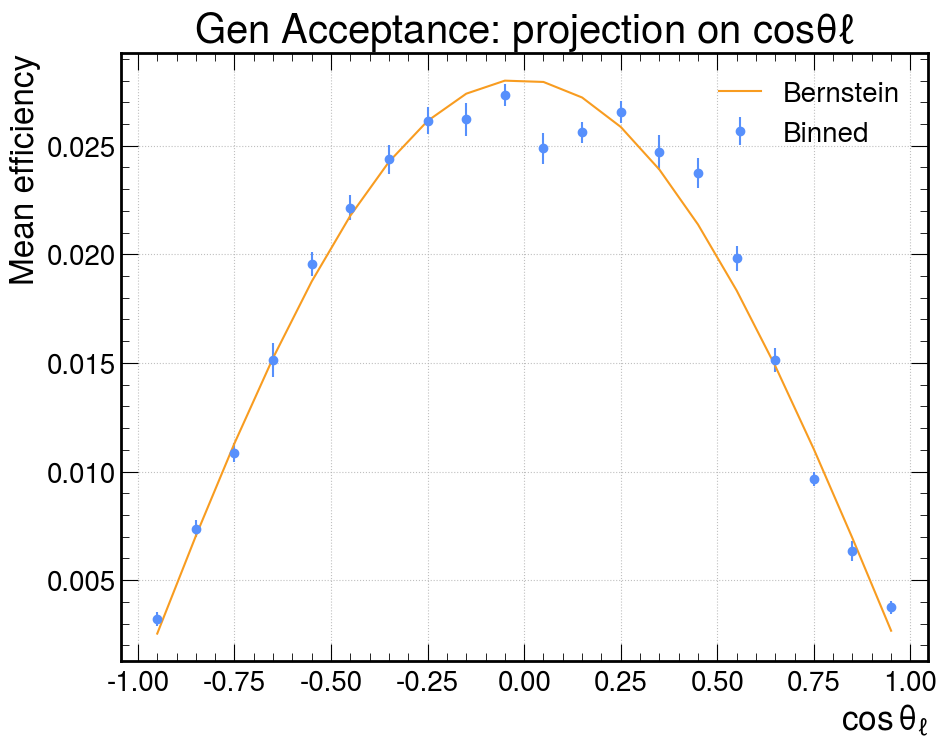

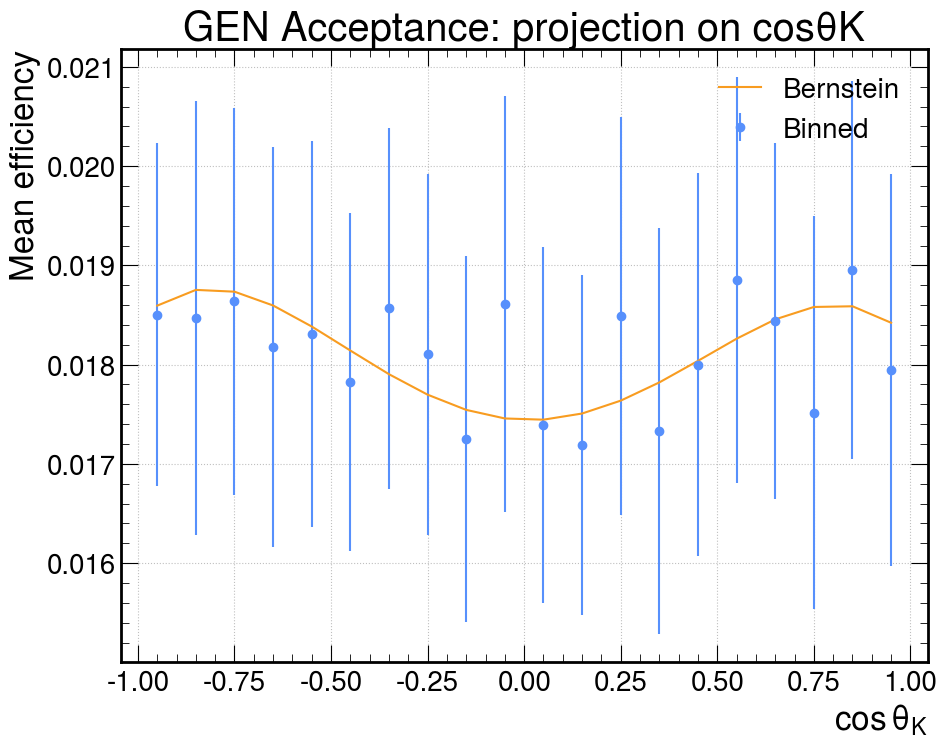

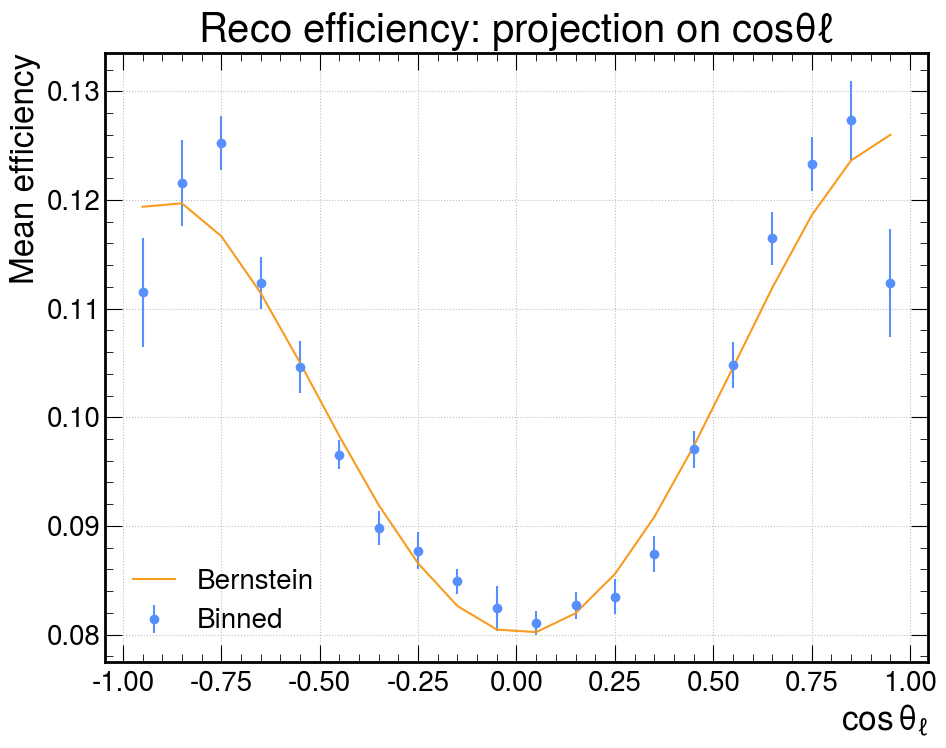

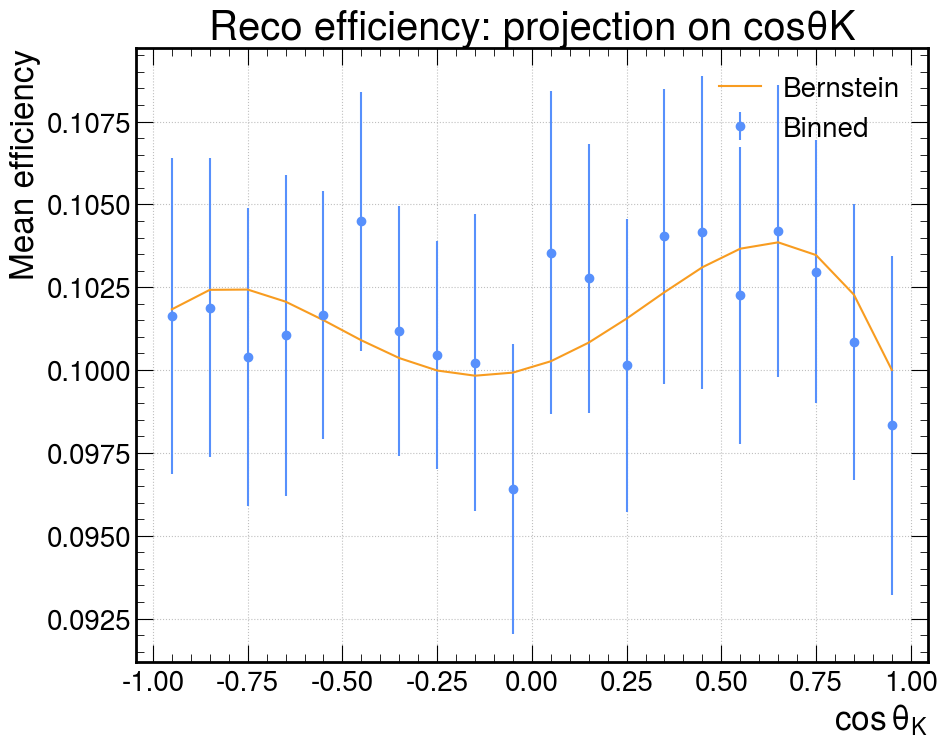

In [10]:
acc_model_file = f"acc_gen_model_{binN}.json"
reco_model_file = f"eff_reco_model_{binN}.json"

save_bernstein2d_model(reco_model_file, coef_reco, nx_rec, ny_rec)
save_bernstein2d_model(acc_model_file, coef_acc, nx_gen, ny_gen)
#reco_model = load_bernstein2d_model(reco_model_file)


# -------------------------------
# Evaluate models on grid
# -------------------------------
#XX, YY = np.meshgrid(xcenters, ycenters, indexing="ij")
#xflat = XX.ravel()
#yflat = YY.ravel()
#eff_flat = eff2d.ravel()

#reco_model_map = bernstein2d_eval(XX, YY, reco_model)
#eff_total_model = acc_model_map * reco_model_map

# -------------------------------
# Projections: Acceptance
# -------------------------------
plot_projection_x_with_errors(
    xcenters, acc_gen, acc_gen_model, mask_gen,
    r"Gen Acceptance: projection on cos$\theta\ell$"
)

plot_projection_y_with_errors(
    ycenters, acc_gen, acc_gen_model, mask_gen,
    "GEN Acceptance: projection on cosθK"
)

# -------------------------------
# Projections: Reconstruction
# -------------------------------



plot_projection_x_with_errors(
    xcenters, eff_reco, eff_reco_model, mask_gen,
    r"Reco efficiency: projection on cos$\theta\ell$"
)

plot_projection_y_with_errors(
    ycenters, eff_reco, eff_reco_model, mask_gen,
    "Reco efficiency: projection on cosθK"
)


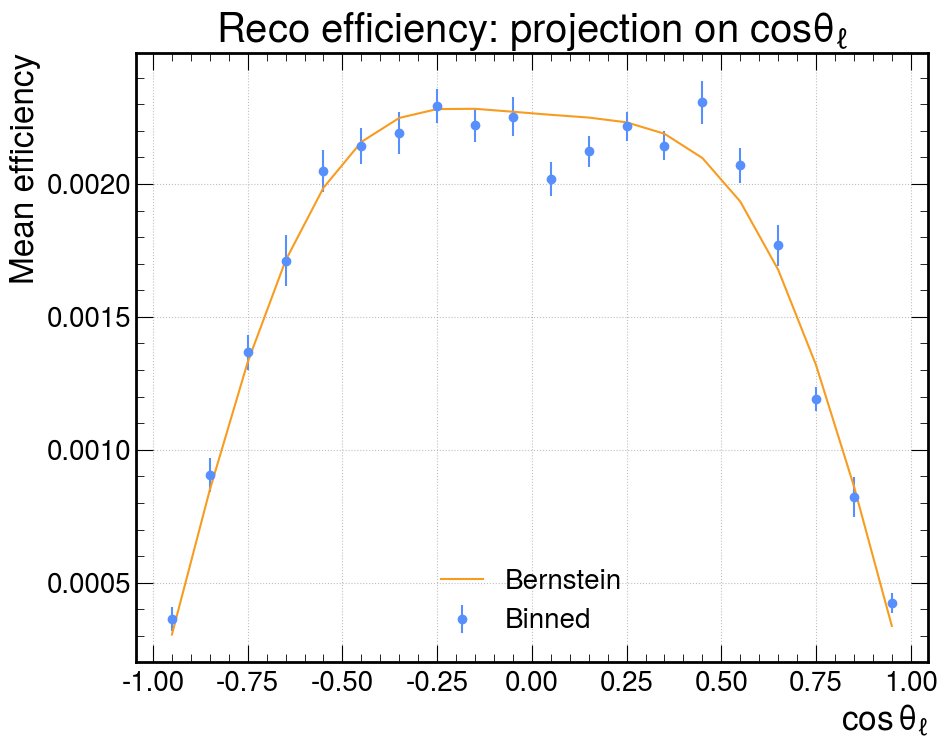

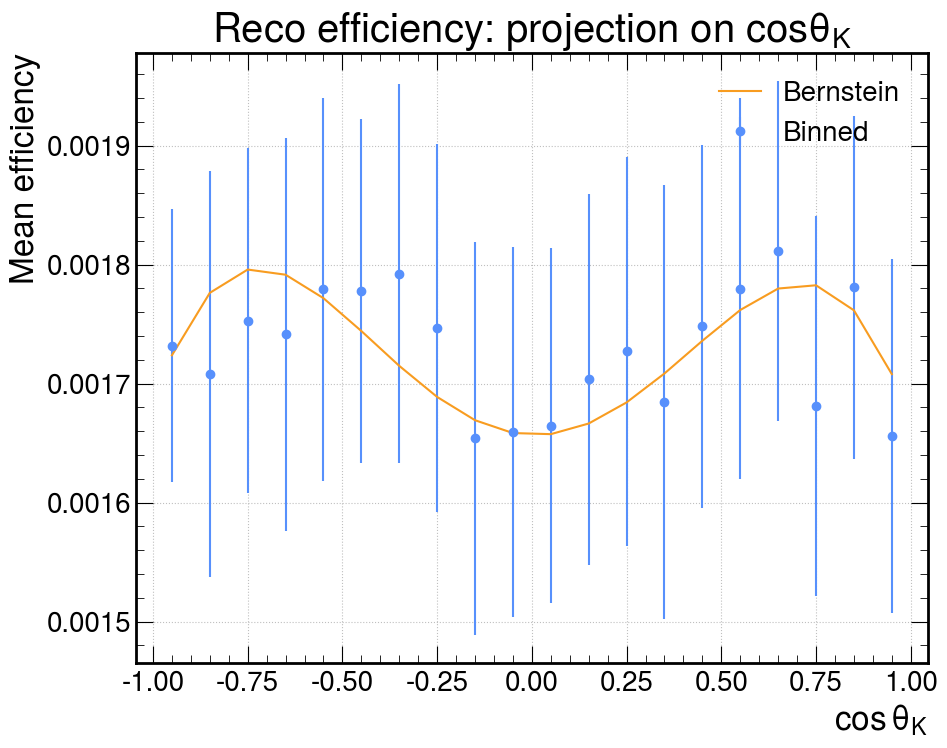

In [13]:
plot_projection_x_with_errors(
    xcenters, acc_gen*eff_reco, acc_gen_model*eff_reco_model, mask_gen,
    r"Reco efficiency: projection on cos$\theta_\ell$"
)

plot_projection_y_with_errors(
    xcenters, acc_gen*eff_reco, acc_gen_model*eff_reco_model, mask_gen,
    r"Reco efficiency: projection on cos$\theta_K$"
)

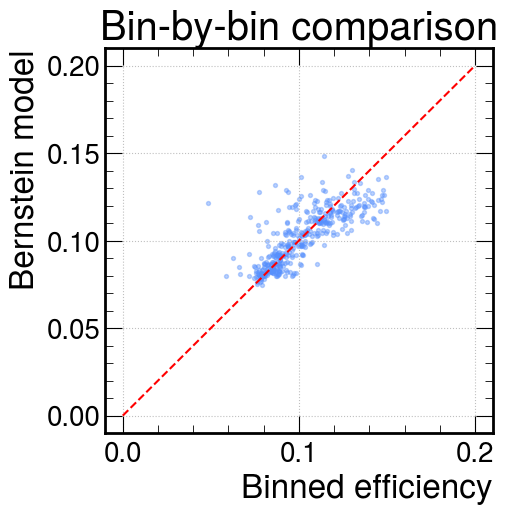

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(
    eff_reco[mask_gen],
    eff_reco_model[mask_gen],
    s=8, alpha=0.4
)
plt.plot([0,0.2], [0,0.2], "r--")
plt.xlabel("Binned efficiency")
plt.ylabel("Bernstein model")
plt.grid(True)
plt.title("Bin-by-bin comparison")
plt.show()

In [14]:
### E F F I C I E N C Y 
import tensorflow as tf
import math
import zfit
from zfit import z


def bernstein_1d_tf(n, k, t):
    """
    Bernstein polynomial B_{n,k}(t), t in [0,1]
    """
    binom = math.comb(n, k)
    return binom * tf.pow(t, k) * tf.pow(1.0 - t, n - k)

def bernstein2d_tf(x, y, coef, nx, ny):
    """
    Evaluate a fixed Bernstein2D efficiency model in TF.

    x, y : tf.Tensor in [-1, 1]
    coef : tf.Tensor shape ((nx+1)*(ny+1),)
    """

    # map [-1,1] → [0,1]
    tx = 0.5 * (x + 1.0)
    ty = 0.5 * (y + 1.0)

    eff = tf.zeros_like(tx, dtype=tf.float64)

    idx = 0
    for i in range(nx + 1):
        Bx = bernstein_1d_tf(nx, i, tx)
        for j in range(ny + 1):
            By = bernstein_1d_tf(ny, j, ty)
            eff += coef[idx] * Bx * By
            idx += 1

    return eff



class BernsteinEfficiency2D(zfit.pdf.BasePDF):

    def __init__(self, obs, coef, nx, ny, name="BernsteinEff2D"):
        self.coef = tf.constant(coef, dtype=tf.float64)
        self.nx = nx
        self.ny = ny
        super().__init__(obs=obs, params={}, name=name)

    def _unnormalized_pdf(self, x):
        cos_l = x.unstack_x("cos_l")
        cos_k = x.unstack_x("cos_k")

        return bernstein2d_tf(
            cos_l,
            cos_k,
            self.coef,
            self.nx,
            self.ny
        )

def acc_model_tf(x, y):
    return bernstein2d_tf(x, y, acc_coef_tf, nx_acc, ny_acc)

def reco_model_tf(x, y):
    return bernstein2d_tf(x, y, reco_coef_tf, nx_reco, ny_reco)

def eff_total_model_tf(cos_theta_l, cos_theta_k):
    acc  = acc_model_tf(cos_theta_l, cos_theta_k)
    reco = reco_model_tf(cos_theta_l, cos_theta_k)
    eff  = acc * reco
    return tf.clip_by_value(eff, 1e-6, 1.0)

## T H E O R Y

class DecayRate_BsTomumuphi_short_tanhhat(zfit.pdf.BasePDF):
    def __init__(self, Fhat_L, Ahat_6, obs):
        params = {'Fhat_L': Fhat_L, 'Ahat_6': Ahat_6}
        super().__init__(obs=obs, params=params)
    def _unnormalized_pdf(self, x):
        cos_l, cos_k = zfit.z.unstack_x(x)
        Fhat_L = self.params['Fhat_L']
        Ahat_6 = self.params['Ahat_6']
        FL = 0.5 + 0.5 * tf.math.tanh(Fhat_L)
        A6 = (0.5 - 0.5*tf.math.tanh(Fhat_L))* tf.math.tanh(Ahat_6)
        cos2_k = tf.square(cos_k)
        cos2_l = tf.square(cos_l)
        term1 = (9./32.) * (1 - FL) * (1 - cos2_k) * (1 + cos2_l)
        term2 = (9./8.) * FL * cos2_k * (1 - cos2_l)
        term3 = (9./16.) * A6 * (1 - cos2_k) * cos_l
        pdf = term1 + term2 + term3
        pdf = tf.where(tf.math.is_nan(pdf), tf.zeros_like(pdf), pdf)
        pdf = tf.clip_by_value(pdf, 1e-12, np.inf)

        return pdf

class SignalPDF_WithEfficiency_tanhhat(zfit.pdf.BasePDF):
    def __init__(self, Fhat_L, Ahat_6, obs):
        params = {'Fhat_L': Fhat_L, 'Ahat_6': Ahat_6}
        super().__init__(obs=obs, params=params)
    def _unnormalized_pdf(self, x):
        cos_l, cos_k = zfit.z.unstack_x(x)
        Fhat_L = self.params['Fhat_L']
        Ahat_6 = self.params['Ahat_6']
        FL = 0.5 + 0.5 * tf.math.tanh(Fhat_L)
        A6 = (0.5 - 0.5*tf.math.tanh(Fhat_L))* tf.math.tanh(Ahat_6)
        cos2_k = tf.square(cos_k)
        cos2_l = tf.square(cos_l)
        term1 = (9./32.) * (1 - FL) * (1 - cos2_k) * (1 + cos2_l)
        term2 = (9./8.) * FL * cos2_k * (1 - cos2_l)
        term3 = (9./16.) * A6 * (1 - cos2_k) * cos_l
        pdf_phys = term1 + term2 + term3

        pdf_phys = tf.clip_by_value(pdf_phys, 1e-12, np.inf)

        # ---------- Efficiency ----------
        eff = eff_total_model_tf(cos_l, cos_k)

        return pdf_phys * eff



class DecayRate_BsTomumuphi_short(zfit.pdf.BasePDF):

    def __init__(self, FL, S2s, S2c, AFB, obs, name="AngularSig"):
        params = {'FL': FL, 'S2s': S2s, 'S2c': S2c, 'AFB': AFB}
        super().__init__(obs=obs, params=params, name=name)

    def _unnormalized_pdf(self, x):

        cos_l, cos_k = z.unstack_x(x)

        FL  = self.params['FL']
        S2s = self.params['S2s']
        S2c = self.params['S2c']
        AFB = self.params['AFB']

        sin_k = tf.sqrt(1. - tf.square(cos_k))
        cos2_l = 2. * tf.square(cos_l) - 1.

        term1 = (9./16.) * ((0.5 * (1. - FL)) + (1./3.) * S2s) * tf.square(sin_k)
        term2 = (9./16.) * (FL + (1./3.) * S2c) * tf.square(cos_k)
        term3 = (9./16.) * (S2s * tf.square(sin_k) + S2c * tf.square(cos_k)) * cos2_l
        term4 = (9./16.) * (2./3.) * AFB * tf.square(sin_k) * cos_l

        pdf = term1 + term2 + term3 + term4
        pdf = tf.where(tf.math.is_nan(pdf), tf.zeros_like(pdf), pdf)

        return pdf

class SignalPDF_WithEfficiency(zfit.pdf.BasePDF):

    def __init__(self, FL, S2s, S2c, AFB, obs, name="SignalEff"):
        params = {'FL': FL, 'S2s': S2s, 'S2c': S2c, 'AFB': AFB}
        super().__init__(obs=obs, params=params, name=name)

    def _unnormalized_pdf(self, x):

        cos_l, cos_k = z.unstack_x(x)

        # física
        FL  = self.params['FL']
        S2s = self.params['S2s']
        S2c = self.params['S2c']
        AFB = self.params['AFB']

        sin_k = tf.sqrt(1. - tf.square(cos_k))
        cos2_l = 2. * tf.square(cos_l) - 1.

        term1 = (9./16.) * ((0.5 * (1. - FL)) + (1./3.) * S2s) * tf.square(sin_k)
        term2 = (9./16.) * (FL + (1./3.) * S2c) * tf.square(cos_k)
        term3 = (9./16.) * (S2s * tf.square(sin_k) + S2c * tf.square(cos_k)) * cos2_l
        term4 = (9./16.) * (2./3.) * AFB * tf.square(sin_k) * cos_l

        pdf_phys = term1 + term2 + term3 + term4
        pdf_phys = tf.clip_by_value(pdf_phys, 1e-12, np.inf)

        # ---------- Efficiency ----------
        eff = eff_total_model_tf(cos_l, cos_k)

        return pdf_phys * eff


def FL_from_Fhat(Fhat_L):
    return 0.5 + 0.5 * np.tanh(Fhat_L)
def A6_from_Ahat_Fhat(Ahat_6, Fhat_L):
    FL = FL_from_Fhat(Fhat_L)
    return (1 - FL) * np.tanh(Ahat_6)

def run_fit(model, data):
    nll = zfit.loss.UnbinnedNLL(model=model, data=data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    err = None
    try:
        err, _ = result.errors(name="minos", method="minuit_minos", cl=0.682)
    except Exception as e:
        print("MINOS failed:", e)
    return result, err

2026-01-29 17:57:04.482638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-29 17:57:04.962087: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-29 17:57:05.131618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769731025.472033 2767252 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769731025.547136 2767252 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769731026.189728 2767252 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [12]:

# -- Angular spaces --
cos_l = zfit.Space('cos_l', limits=(-1, 1))
cos_k = zfit.Space('cos_k', limits=(-1, 1))
obs_ang = cos_l * cos_k

FL = zfit.Parameter('FL', 0.5, lower=0., upper=1)
S2s = zfit.Parameter('S2s', 0.0, lower=-1, upper=1)
S2c = zfit.Parameter('S2c', 0.0, lower=-1, upper=1)
AFB = zfit.Parameter('AFB', 0.0, lower=-1, upper=1)


pdf_ang_trans = DecayRate_BsTomumuphi_short(FL ,S2s ,S2c, AFB, obs_ang)


coef_acc, nx_acc, ny_acc = load_bernstein_model(acc_model_file)
coef_reco, nx_reco, ny_reco = load_bernstein_model(reco_model_file)
acc_coef_tf  = tf.constant(coef_acc,  dtype=tf.float64)
reco_coef_tf = tf.constant(coef_reco, dtype=tf.float64)

pdf_sig = SignalPDF_WithEfficiency(FL ,S2s ,S2c, AFB, obs_ang)


# -- Data --

obs_Gen_q2 =   select_q2_bin(obs_Gen, binN, "q2Gen")
obs_RecoFtr_q2 =   select_q2_bin(obs_RecoFtr,binN, "q2Gen")

data_true = zfit.Data.from_numpy(array=obs_Gen_q2[["costhetalGen", "costhetakGen"]].to_numpy(), obs=obs_ang)
data_reco = zfit.Data.from_numpy(array=obs_RecoFtr_q2[["costhetal", "costhetak"]].to_numpy(), obs=obs_ang)

# --- FIT TRUTH ---

result_true, tminos_err = run_fit(pdf_ang_trans, data_true)
print("True Results")
print(result_true)


'''
FL_tfit = FL.value()
S2s_tfit = S2s.value() 
S2c_tfit = S2c.value() 
AFB_tfit = AFB.value()

FL_tminos = tminos_err[FL]
S2s_tminos = tminos_err[S2s] 
S2c_tminos = tminos_err[S2c] 
AFB_tminos = tminos_err[AFB]
 
FL_terror = [-FL_tminos["lower"], FL_tminos["upper"]]
S2s_terror = [-S2s_tminos["lower"], S2s_tminos["upper"]]
S2c_terror = [-S2c_tminos["lower"], S2c_tminos["upper"]]
AFB_terror= [-AFB_tminos["lower"],AFB_tminos["upper"]]
'''


# --- FIT RECO ---
result, minos_err = run_fit(pdf_sig, data_reco)

print("Reco Results")
print(result)




2026-01-12 15:27:32.545317: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


True Results
FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.DecayRate_BsTomumuphi_short'>  params=[AFB, FL, S2c, S2s]] data=[<zfit.Data: Data obs=('cos_l', 'cos_k') shape=(157314, 2)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.8e-07 │        211191.33 |  5196.506 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)                minos    at limit
------  ------------------  -------------------  ----------
FL                0.462184  - 0.0019   + 0.0019       False
S2s               0.103352  - 0.0019   + 0.0019       False
S2c              -0.338128  - 0.0028   + 0.0028       False
AFB           -

In [ ]:
from iminuit import Minuit

# -- Angular spaces --
cos_l = zfit.Space('cos_l', limits=(-1, 1))
cos_k = zfit.Space('cos_k', limits=(-1, 1))
obs_ang = cos_l * cos_k


Fhat_L = zfit.Parameter('Fhat_L', 0.0)
Ahat_6 = zfit.Parameter('Ahat_6', 0.0)


pdf_ang_trans = DecayRate_BsTomumuphi_short_tanhhat(Fhat_L , Ahat_6, obs_ang)

coef_acc, nx_acc, ny_acc = load_bernstein_model(acc_model_file)
coef_reco, nx_reco, ny_reco = load_bernstein_model(reco_model_file)
acc_coef_tf  = tf.constant(coef_acc,  dtype=tf.float64)
reco_coef_tf = tf.constant(coef_reco, dtype=tf.float64)

pdf_sig = SignalPDF_WithEfficiency_tanhhat(Fhat_L , Ahat_6, obs_ang)


# -- Data --

obs_Gen_q2 =   select_q2_bin(obs_Gen, binN, "q2Gen")
obs_RecoFtr_q2 =   select_q2_bin(obs_RecoFtr,binN, "q2Gen")

data_true = zfit.Data.from_numpy(array=obs_Gen_q2[["costhetalGen", "costhetakGen"]].to_numpy(), obs=obs_ang)
data_reco = zfit.Data.from_numpy(array=obs_RecoFtr_q2[["costhetal", "costhetak"]].to_numpy(), obs=obs_ang)

# --- FIT TRUTH ---

result_true, tminos_err = run_fit(pdf_ang_trans, data_true)
print("\n****** T R U E   R E S U L T S  ********")
print(result_true)


# --- Truth contour ---
Fhat_L_tfit = Fhat_L.value()
Ahat_6_tfit = Ahat_6.value()

def nll_wrap(Fhat_L_tval, Ahat_6_tval):
    Fhat_L.set_value(Fhat_L_tval)
    Ahat_6.set_value(Ahat_6_tval)
    return zfit.loss.UnbinnedNLL(model=pdf_ang_trans, data=data_true).value()

m_true = Minuit(nll_wrap, Fhat_L_tval=Fhat_L_tfit, Ahat_6_tval=Ahat_6_tfit)
m_true.errordef = 0.5
m_true.migrad()
m_true.minos()

merror_FL_t = m_true.merrors['Fhat_L_tval']
merror_A6_t = m_true.merrors['Ahat_6_tval']
Fhat_L_terr = [abs(merror_FL_t.lower), abs(merror_FL_t.upper)] 
Ahat_6_terr = [abs(merror_A6_t.lower), abs(merror_A6_t.upper)]

contour_true = m_true.mncontour('Fhat_L_tval', 'Ahat_6_tval', cl=0.3935, size=50)
y_tcontour, x_tcontour = zip(*contour_true)
FL_tcontour = FL_from_Fhat(np.array(y_tcontour))

FL_terror = [FL_from_Fhat(Fhat_L_tfit)-min(FL_tcontour), 
             max(FL_tcontour)- FL_from_Fhat(Fhat_L_tfit)]

A6_tcontour = A6_from_Ahat_Fhat(np.array(x_tcontour), np.array(y_tcontour))
A6_terror = [A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit) - min(A6_tcontour), 
             max(A6_tcontour)-A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit)]

print(f"FL    ={FL_from_Fhat(Fhat_L_tfit):.4f} [{FL_terror[0]:.4f}, {FL_terror[1]:.4f}]") 
print(f"A6    ={A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit):.4f}  [{A6_terror[0]:.4f}, {A6_terror[1]:.4f}]")


# --- FIT RECO ---
result, minos_err = run_fit(pdf_sig, data_reco)

print("\n****** R E C O   R E S U L T S  ********")
print(result)

Fhat_L_fit = Fhat_L.value()
Ahat_6_fit = Ahat_6.value()
# --- Reco contour ---
def nll_wrap(Fhat_L_val, Ahat_6_val):
    Fhat_L.set_value(Fhat_L_val)
    Ahat_6.set_value(Ahat_6_val)
    return zfit.loss.UnbinnedNLL(model=pdf_sig, data=data_reco).value()

m = Minuit(nll_wrap, Fhat_L_val=Fhat_L_fit, Ahat_6_val=Ahat_6_fit)
m.errordef = 0.5
m.migrad()
m.minos()

merror_FL = m.merrors['Fhat_L_val']
merror_A6 = m.merrors['Ahat_6_val']
Fhat_L_err = [abs(merror_FL.lower), abs(merror_FL.upper)] 
Ahat_6_err = [abs(merror_A6.lower), abs(merror_A6.upper)]


contour = m.mncontour('Fhat_L_val', 'Ahat_6_val', cl=0.3935, size=50)
y_contour, x_contour = zip(*contour)
FL_contour = FL_from_Fhat(np.array(y_contour))
FL_error = [FL_from_Fhat(Fhat_L_fit)-min(FL_contour), max(FL_contour)-FL_from_Fhat(Fhat_L_fit)]
A6_contour = A6_from_Ahat_Fhat(np.array(x_contour), np.array(y_contour))
A6_error = [A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit)-min(A6_contour), max(A6_contour)- A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit)]

print(f"FL = {FL_from_Fhat(Fhat_L_fit):.4f} [{float(FL_error[0]):.4f}, {float(FL_error[1]):.4f}]") 
print(f"A6    ={A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit):.4f}  [{float(A6_error[0]):.4f}, {float(A6_error[1]):.4f}]")


2026-01-29 17:57:14.849362: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



****** T R U E   R E S U L T S  ********
FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.DecayRate_BsTomumuphi_short_tanhhat'>  params=[Ahat_6, Fhat_L]] data=[<zfit.Data: Data obs=('cos_l', 'cos_k') shape=(150683, 2)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00032 │        176135.20 |  371.3836 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)                minos    at limit
------  ------------------  -------------------  ----------
Fhat_L            0.552362  - 0.0044   + 0.0043       False
Ahat_6         -0.00406735  -  0.008   + 0.0078       False
FL    =0.7511 [0.0017, 0.0016]
A6    =-0.

In [19]:
def to_serializable(val):
    # Handles scalars and lists/arrays of tensors
    if hasattr(val, 'numpy'):
        return float(val.numpy())
    elif isinstance(val, (list, tuple, np.ndarray)):
        return [to_serializable(v) for v in val]
    else:
        return float(val) if isinstance(val, np.generic) else val

def save_results_and_contours(prefix, ERA, binN, Fhat_L_val, Fhat_L_err, 
                              Ahat_6_val, Ahat_6_err, 
                              FL_val, FL_err, A6_val, A6_err, 
                              xcontour, ycontour, FLcontour, A6contour):
    result = {
        "Fhat_L": to_serializable(Fhat_L_val),
        "Fhat_L_error": to_serializable(Fhat_L_err),
        "Ahat_6": to_serializable(Ahat_6_val),
        "Ahat_6_error": to_serializable(Ahat_6_err),
        "FL": to_serializable(FL_val),
        "FL_error": to_serializable(FL_err),
        "A6": to_serializable(A6_val),
        "A6_error": to_serializable(A6_err)
    }
    contour = {
        "Ahat_6_contour": to_serializable(xcontour),
        "Fhat_L_contour": to_serializable(ycontour),
        "FL_contour": to_serializable(FLcontour),
        "A6_contour": to_serializable(A6contour)
    }
    with open(f"angularVal{ERA}/{prefix}_fit_{ERA}_{binN}.json", "w") as f:
        json.dump(result, f, indent=2)
    with open(f"angularVal{ERA}/{prefix}_contour_{ERA}_{binN}.json", "w") as f:
        json.dump(contour, f, indent=2)


In [28]:
save_results_and_contours(
    "test6_true", ERA, binN,
    Fhat_L_tfit, Fhat_L_terr,
    Ahat_6_tfit, Ahat_6_terr,
    float(FL_from_Fhat(Fhat_L_tfit)),  FL_terror,
    float(A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit)), A6_terror,
    x_tcontour, y_tcontour, FL_tcontour, A6_tcontour
)
save_results_and_contours(
    "test6_reco", ERA, binN,
    Fhat_L_fit, Fhat_L_err,
    Ahat_6_fit, Ahat_6_err,
    float(FL_from_Fhat(Fhat_L_fit)), FL_error,
    float(A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit)), A6_error,
    x_contour, y_contour, FL_contour, A6_contour
)